<a href="https://colab.research.google.com/github/Cryptonex7/covid19-analysis/blob/collab-files/SarthakTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing  Libraries

In [0]:
# Imports
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

# Supress Warnings
import warnings
warnings.simplefilter('ignore')

In [0]:
# Function for fetching url
import requests

def get(url):
  try:
    response = requests.get(url)
    print(f"Request returned {response.status_code} : '{response.reason}'")
    return response.json()
  except requests.HTTPError:
    print(response.status_code, response.reason)
    raise

## Fetching Data

In [3]:
# Fetching and Parsing the data
raw_data = get('https://api.covid19india.org/raw_data.json')
raw_data = raw_data['raw_data']

Request returned 200 : 'OK'


### Web Scraping

In [0]:
# Function for fetching url
import requests

def get(url):
  try:
    response = requests.get(url)
    print(f"Request returned {response.status_code} : '{response.reason}'")
    return response.json()
  except requests.HTTPError:
    print(response.status_code, response.reason)
    raise

In [0]:
# Fetching data from 2nd source
from datetime import datetime
import requests
import os
import glob
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [0]:
link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSc_2y5N0I67wDU38DjDh35IZSIS30rQf7_NYZhtYYGU1jJYT6_kDx4YpF-qw0LSlGsBYP8pqM_a1Pd/pubhtml#'
req = requests.get(link)
soup = BeautifulSoup(req.content, "html.parser")

In [0]:
def getDataFromSheet(id, index):
  table = soup.find(id=id).div.table
  tbody = table.tbody
  body = tbody.find_all('tr')

  body_rows = []
    
  for tr in body:
      td = tr.find_all(['th', 'td'])
      row = [i.text for i in td]
      body_rows.append(row)
    
  data = pd.DataFrame(body_rows[index:len(body_rows)], columns=body_rows[0])

  data.drop(data.columns[0], axis='columns', inplace=True)
  return data

#### Statewise data

In [0]:
# And there we have it! the data, the Statewise data

statewise_data = getDataFromSheet(id='1896310216', index=1)
statewise_data.drop(statewise_data.index[1], axis='index', inplace=True)

In [9]:
# Import gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
statewise_data.columns

Index(['State', '', 'Confirmed', 'Recovered', 'Deaths', 'Active',
       'Last_Updated_Time', 'State_code', 'Delta_Confirmed', 'Delta_Recovered',
       'Delta_Deaths', 'State_Notes'],
      dtype='object')

#### Death and Recovered Data

In [11]:
# Fetching Death and Recovered Data
death_and_recovered = getDataFromSheet(id='200733542', index=2)
death_and_recovered.head()

,Sl_No,Date,Age Bracket,Gender,Patient_Status,City,District,State,Statecode,Notes,Nationality,Source_1,Source_2,Source_3,Patient_Number (Could be mapped later),,,,,,,
0,1,29/03/2020,85,M,Deceased,Mumbai,Mumbai,Maharashtra,MH,"Suffering from Diabetes, had a pacemaker, no t...",,https://arogya.maharashtra.gov.in/pdf/epressno...,https://www.deccanherald.com/national/west/dea...,,,,,,,,,
1,2,29/03/2020,80,M,Deceased,Mumbai,Mumbai,Maharashtra,MH,"patient passed away at the Fortis Hospital, Mu...",,https://arogya.maharashtra.gov.in/pdf/epressno...,https://www.indiatoday.in/india/story/coronavi...,,,,,,,,,
2,3,29/03/2020,86,F,Deceased,Ghatkopar,Mumbai Suburban,Maharashtra,MH,,,https://arogya.maharashtra.gov.in/pdf/epressno...,,,,,,,,,,
3,4,29/03/2020,,,Deceased,,Mumbai,Maharashtra,MH,,,https://arogya.maharashtra.gov.in/pdf/epressno...,,,,,,,,,,
4,5,29/03/2020,,,Deceased,,Mumbai,Maharashtra,MH,,,https://arogya.maharashtra.gov.in/pdf/epressno...,,,,,,,,,,


### Normalize the fetched JSON

In [12]:
#add
from datetime import datetime

file_loc = datetime.today().strftime('%Y-%m-%d')

# Import gdrive
from google.colab import drive
drive.mount('/drive')

# JSON to dataframe
from pandas.io.json import json_normalize
data = json_normalize(raw_data)

Mounted at /drive


# Date Wrangling

In [0]:
statewise_data.drop('',axis=1,inplace=True)

In [0]:
data = data.rename(columns={"patientnumber": "ID",
                     "statepatientnumber": "Government id",
                     "dateannounced": "Diagnosed date",
                     "agebracket": "Age",
                     "gender": "Gender",
                     "detectedcity": "Detected city",
                     "detecteddistrict": "Detected district",
                     "detectedstate": "Detected state",
                     "nationality": "Nationality",
                     "currentstatus": "Current status",
                     "statuschangedate": "Status change date",
                     "_d180g": "Notes",
                     "backupnotes": "Backup notes",
                     "contractedfromwhichpatientsuspected": "Contracted from which Patient (Suspected)",
                     "estimatedonsetdate": "Estimated on set date",
                     "source1": "Source 1",
                     "source2": "Source 2",
                     "source3": "Source 3"}
                   )

In [0]:
# changing nationality Indian to India
for ind in data.index:
  if(data['Nationality'][ind] == "Indian"):
    data['Nationality'][ind] = "India"

In [0]:
#converting the string values to datetime object
data['Diagnosed date'] = pd.to_datetime(data['Diagnosed date'],dayfirst=True)
data['Status change date'] = pd.to_datetime(data['Status change date'],dayfirst=True)

In [0]:
#replacing all the missing values with unknown
data.replace(to_replace ="", 
                 value ="unknown", inplace=True)
#creating new columns depicting the current status of patient
data['recovered'] = 0
data['active'] = 0
data['death'] = 0
data['unknown'] = 0
data['confirmed'] = 1

In [18]:
for status in data.index:  
  if(data['Current status'][status] == "Hospitalized"):
    data['active'][status] = 1
  elif(data['Current status'][status] == "Recovered"):
    data['recovered'][status] = 1
  elif(data['Current status'][status] == "Deceased"):
    data['death'][status] = 1
  else:
    data['unknown'][status] = 1   

data[['Current status','recovered','active','death','unknown']].sample(5)

,Current status,recovered,active,death,unknown
2214,Hospitalized,0,1,0,0
1131,Hospitalized,0,1,0,0
13205,Hospitalized,0,1,0,0
12561,Hospitalized,0,1,0,0
10398,Hospitalized,0,1,0,0


In [19]:
statewise_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 38
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   State              38 non-null     object
 1   Confirmed          38 non-null     object
 2   Recovered          38 non-null     object
 3   Deaths             38 non-null     object
 4   Active             38 non-null     object
 5   Last_Updated_Time  38 non-null     object
 6   State_code         38 non-null     object
 7   Delta_Confirmed    38 non-null     object
 8   Delta_Recovered    38 non-null     object
 9   Delta_Deaths       38 non-null     object
 10  State_Notes        38 non-null     object
dtypes: object(11)
memory usage: 3.6+ KB


In [0]:
statewise_data['Confirmed'] = statewise_data['Confirmed'].astype(float)
statewise_data['Recovered'] = statewise_data['Recovered'].astype(float)
statewise_data['Deaths'] = statewise_data['Deaths'].astype(float)
statewise_data['Active'] = statewise_data['Active'].astype(float)
statewise_data['Delta_Recovered'] = statewise_data['Delta_Confirmed'].astype(float)
statewise_data['Delta_Deaths'] = statewise_data['Delta_Deaths'].astype(float)

In [0]:
# For death_and_recovered Dataset
death_and_recovered.drop([''],axis=1,inplace=True)
death_and_recovered['Date'] = pd.to_datetime(death_and_recovered['Date'],dayfirst=True)

death_and_recovered['recovered'] = 0
death_and_recovered['death'] = 0
for status in death_and_recovered.index:
  if(death_and_recovered['Patient_Status'][status] == "Recovered"):
    death_and_recovered['recovered'][status] = 1
  elif(death_and_recovered['Patient_Status'][status] == "Deceased"):
    death_and_recovered['death'][status] = 1
  elif(death_and_recovered['Patient_Status'][status] == "Deceased#"):
    death_and_recovered['death'][status] = 1 



# Understanding the Data

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13502 entries, 0 to 13501
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Age                                        13502 non-null  object        
 1   Backup notes                               13502 non-null  object        
 2   Contracted from which Patient (Suspected)  13502 non-null  object        
 3   Current status                             13502 non-null  object        
 4   Diagnosed date                             13455 non-null  datetime64[ns]
 5   Detected city                              13502 non-null  object        
 6   Detected district                          13502 non-null  object        
 7   Detected state                             13502 non-null  object        
 8   Estimated on set date                      13502 non-null  object        
 9   Gender           

In [23]:
data.sample(5)

,Age,Backup notes,Contracted from which Patient (Suspected),Current status,Diagnosed date,Detected city,Detected district,Detected state,Estimated on set date,Gender,Nationality,notes,ID,Source 1,Source 2,Source 3,statecode,Government id,Status change date,typeoftransmission,recovered,active,death,unknown,confirmed
1581,36,unknown,unknown,Hospitalized,2020-03-31,unknown,Siwan,Bihar,unknown,M,unknown,Travelled from Middle East,1582,https://twitter.com/sanjayjavin/status/1245006...,https://twitter.com/ANI/status/124500860449671...,unknown,BR,unknown,2020-03-31,Imported,0,1,0,0,1
11960,unknown,unknown,unknown,Hospitalized,2020-04-15,unknown,Mumbai,Maharashtra,unknown,unknown,unknown,Details awaited,11961,https://twitter.com/ANI/status/125043632276379...,https://twitter.com/rajeshtope11/status/125044...,unknown,MH,unknown,2020-04-15,unknown,0,1,0,0,1
4039,unknown,unknown,unknown,Hospitalized,2020-04-05,unknown,Tonk,Rajasthan,unknown,unknown,unknown,Details Awaited,4040,https://twitter.com/ANI/status/124678935979111...,unknown,unknown,RJ,unknown,2020-04-05,unknown,0,1,0,0,1
6205,69,unknown,unknown,Hospitalized,2020-04-09,unknown,Khordha,Odisha,unknown,M,unknown,Brought in ambulance directly from WB,6206,https://twitter.com/HFWOdisha/status/124814391...,unknown,unknown,OR,unknown,2020-04-09,unknown,0,1,0,0,1
1972,unknown,unknown,E0,Hospitalized,2020-04-01,unknown,Jorhat,Assam,unknown,unknown,unknown,Travelled to Delhi,1973,https://twitter.com/himantabiswa/status/124537...,https://twitter.com/PTI_News/status/1245377181...,unknown,AS,unknown,2020-04-01,Local,0,1,0,0,1


In [24]:
print("External Data")
print(f"First recorded Case: {data['Diagnosed date'].min()}")
print(f"Last recorded Case: {data['Diagnosed date'].max()}")
print(f"Total Days recorded: {data['Diagnosed date'].max() - data['Diagnosed date'].min()}")

External Data
First recorded Case: 2020-01-30 00:00:00
Last recorded Case: 2020-04-17 00:00:00
Total Days recorded: 78 days 00:00:00


# SAVING THE CLEANED DATA TO DRIVE

In [0]:
#add
## RAW DATA

data.to_csv('/drive/My Drive/Covid19/data.csv')

## STATEWISE DATA

statewise_data.to_csv('/drive/My Drive/Covid19/' + file_loc + 'statewise_data.csv')

## DEATH & RECOVERED DATA

death_and_recovered.to_csv('/drive/My Drive/Covid19/' + file_loc + 'death_and_recovered.csv')

# Country Analysis

## 1. Confirmed Cases Over Time


### 1.1 Confirmed Cases ( Cumulative )

In [0]:
grouped = data.groupby('Diagnosed date')['Diagnosed date', 'confirmed'].sum().reset_index()
s=0
grouped['tot_confirmed'] = grouped['confirmed']
for row in grouped.index:
  grouped['tot_confirmed'][row] += s
  s = grouped['tot_confirmed'][row]  

In [27]:
fig = px.line(grouped, x="Diagnosed date", y="tot_confirmed", title="Day Wise Overall Confirmed Cases in India", width=900, height=650)

fig.show()

print("\n")

fig = px.line(grouped, x="Diagnosed date", y="tot_confirmed", title="Day Wise Confirmed Cases in India(Logarithmic Scale)", log_y=True, width=900, height=650)

fig.show()

### 1.2 Confirmed Cases ( Day Wise )

In [28]:
fig = px.line(grouped, x="Diagnosed date", y="confirmed", title="Day Wise Encountered Cases in India", width=900, height=650)

fig.show()

print("\n")

fig = px.line(grouped, x="Diagnosed date", y="confirmed", title="Day Wise Encountred Cases in India(Logarithmic Scale)", log_y=True, width=900, height=650)

fig.show()

## Observation from the above graph:

## 2. Total Confirmed Cases in Various States till Date

In [29]:
statewise_data.columns

Index(['State', 'Confirmed', 'Recovered', 'Deaths', 'Active',
       'Last_Updated_Time', 'State_code', 'Delta_Confirmed', 'Delta_Recovered',
       'Delta_Deaths', 'State_Notes'],
      dtype='object')

In [30]:
statewise_data['Confirmed'] = statewise_data['Confirmed'].astype(float)
#cases state wise
state_grouped = statewise_data.groupby(['State'])['Confirmed'].sum().reset_index()

fig = px.bar(state_grouped[state_grouped['State']!='Total'].sort_values('Confirmed', ascending=False)[:40][::-1], 
             x='Confirmed', y='State',
             title='Confirmed Cases in Various States in India', text='Confirmed', height=800,width = 1400, orientation='h')
fig.show()

In [31]:
latest_grouped = data.groupby('Nationality')['confirmed'].sum().reset_index()
latest_grouped

,Nationality,confirmed
0,Canada,1
1,India,1249
2,Indonesia,15
3,Italy,18
4,Malaysia,1
5,Myanmar,1
6,Phillipines,2
7,Thailand,2
8,Tibet,1
9,United Kingdom,7


In [32]:
fig = px.choropleth(latest_grouped, locations="Nationality", 
                    locationmode='country names', color="confirmed", 
                    hover_name="Nationality", range_color=[1,1500], 
                    color_continuous_scale="peach", scope='world',
                    title='Countries with Confirmed Cases')
#fig.update(layout_coloraxis_showscale=False)
fig.show()

In [33]:
# Remove all the unknown Genders
df_gender_cleaned = data[ (data['Gender'] == "M") | (data['Gender'] == "F")]
print('Percentage of gender unknown = ',(data['Gender'].value_counts()[0]) / (data['Gender'].value_counts().sum())*100)

# Pie Chart
fig = px.pie(df_gender_cleaned,values='confirmed', names='Gender')
fig.show()
print(fig)

Percentage of gender unknown =  80.69174937046364


Figure({
    'data': [{'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
              'hoverlabel': {'namelength': 0},
              'hovertemplate': 'Gender=%{label}<br>confirmed=%{value}',
              'labels': array(['F', 'M', 'M', ..., 'F', 'M', 'F'], dtype=object),
              'legendgroup': '',
              'name': '',
              'showlegend': True,
              'type': 'pie',
              'values': array([1, 1, 1, ..., 1, 1, 1])}],
    'layout': {'legend': {'tracegroupgap': 0}, 'margin': {'t': 60}, 'template': '...'}
})


In [34]:
# Observation
ratio = df_gender_cleaned['Gender'].value_counts()[0] / df_gender_cleaned['Gender'].value_counts()[1]
print("\nAlthough more than 50% of the genders of people affected with covid19 is unknown but from the ones that are known we can see that almost\n{} times the number of Males are getting affected by COVID-19 in India. ".format(0.5*round(ratio/0.5)))


Although more than 50% of the genders of people affected with covid19 is unknown but from the ones that are known we can see that almost
2.0 times the number of Males are getting affected by COVID-19 in India. 


 - This may be indicative of a greater number of males, highlighting the already present gender disparity in India, but at the same time may be attributed to smoking, drinking, general poor health practiced by a greater number of men in the Indian subcontinent as compared to women .

- Since coronavirus spreads from person to person, it is quite obvious that chances of a person getting in contact with coronavirus increases when he/she is at workplace or at some crowded place.
 - According to a website catalyst(https://www.catalyst.org/research/women-in-the-workforce-india/) the male workforce is 78.6% compared to 23.6% of female workforce in India. This can be another reason of more males getting affected with the virus.






## **DISTRICT WISE ANALYSIS**

In [35]:
df_district_cleaned = data[data['Detected district']!="unknown"]

latest_grouped = df_district_cleaned.groupby('Detected district')['confirmed'].sum().reset_index()

fig = px.bar(latest_grouped.sort_values('confirmed', ascending=False)[:20][::-1], 
             x='confirmed', y='Detected district',
             title='20 most affected Districts in India', text='confirmed', height=850, orientation='h')
fig.show()

Maharashtra is heavily affected
> Mumbai being the hub for tourist arrivals and international flights, as well as the most populous city in india and 5th most populous city worldwide has been the most affected city thus far.

>Pune being close to Mumbai (~150 Km) is also affected heavily thanks to inter city travel between the major neighbouring cities.





Here we form a hypothesis that there seems to be a correlation between the cities the virus is spreading in a greater number & said cities being costal areas.

With this hypothesis, let us explore this idea and see if we can reach any conclusions-

In [36]:
data['Detected district'].unique()

array(['Thrissur', 'Alappuzha', 'Kasaragod', 'East Delhi', 'Hyderabad',
       'Italians*', 'Agra', 'South West Delhi', 'Ghaziabad', 'West Delhi',
       'Leh', 'Kancheepuram', 'Pathanamthitta', 'North Delhi', 'Jammu',
       'Bengaluru', 'Kannur', 'Pune', 'Amritsar', 'Ernakulam', 'Kottayam',
       'Jaipur', 'Mumbai', 'S.P.S. Nellore', 'Kalaburagi', 'Nagpur',
       'Lucknow', 'New Delhi', 'Thiruvananthapuram', 'Ahmadnagar',
       'Thane', 'Raigarh', 'Yavatmal', 'Idukki', 'Aurangabad', 'Dehradun',
       'Malappuram', 'Khordha', 'South Delhi', 'Gurugram', 'Kargil',
       'Mahe', 'Gautam Buddha Nagar', 'Kolkata', 'Chennai', 'Ratnagiri',
       'Srinagar', 'Jhunjhunu', 'North East Delhi', 'Chandigarh',
       'Kodagu', 'Prakasam', 'Raipur', 'Kheri',
       'Shahid Bhagat Singh Nagar', 'Rajkot', 'Surat', 'Visakhapatnam',
       'North West Delhi', 'S.A.S. Nagar', 'Ahmadabad', 'Vadodara',
       'Bhilwara', 'Faridabad', 'Panipat', 'Kangra', 'Jabalpur',
       'Karimnagar', 'unknown', 'N

In [37]:
# Finding number of patients in districts with humid climate
most_affected_districts = df_district_cleaned

close_to_water = most_affected_districts[most_affected_districts["Detected district"].isin(["Mumbai", "Kasaragod", "Pune", "Kochi", "Sangli",'Chennai'])] #Ahemdabad is ~326km from the sea, vadodra ~263, "Sangli city is situated on the bank of Krishna river", 

#Segregate the remaining cities
far_from_water = most_affected_districts[~(most_affected_districts["Detected district"].isin(["Mumbai", "Kasaragod", "Pune", "Kochi", "Sangli"]))]

#Calculate the total number of confirmed cases in the two cases
x = close_to_water['confirmed'].sum()
y = far_from_water['confirmed'].sum()

#Lists used to feed the pie chart
labels = ['Close to water','Far from water']
values = [x,y]

# plotting a Pie chart to see the distribution of confirmed cases in the two cases
fig = go.Figure(data=[go.Pie(labels=labels, values = values,pull=0.05)])
fig.show()

From the above data we can say that at this time no such conclusion can be derived, as most of the cases seem to come from inland cities as far as th

# Recovered Cases




##Cumulative Recovered Cases

In [0]:
grouped = death_and_recovered.groupby('Date')['Date', 'recovered'].sum().reset_index()
s=0
grouped['tot_recovered'] = grouped['recovered']
for row in grouped.index:
  grouped['tot_recovered'][row] += s
  s = grouped['tot_recovered'][row]  

In [39]:
fig = px.line(grouped, x="Date", y="tot_recovered", title="Recovered Cases in India(Cumulative)", width=900, height=650)

fig.show()

print("\n")

fig = px.line(grouped, x="Date", y="tot_recovered", title="Recovered Cases in India(Cumulative)(Logarithmic Scale)", log_y=True, width=900, height=650)

fig.show()

## Day Wise Recovered Cases

In [0]:
recovery_daywise = death_and_recovered.groupby('Date')['recovered'].sum().reset_index()

In [41]:
fig = px.line(recovery_daywise, x="Date", y="recovered", title="Recoveries Day Wise in India",
             color_discrete_sequence=['#F42272'])
fig.show()

## District Wise and State Wise Recovered Cases

In [42]:
# district Wise Recovery
latest_grouped = death_and_recovered[death_and_recovered['District']!=''].groupby('District')['recovered'].sum().reset_index()

fig = px.bar(latest_grouped.sort_values('recovered', ascending=False)[:7][::-1], 
             x='recovered', y='District',
             title='Recovered cases district-wise in India: ', text='recovered', height=400, orientation='h')
fig.show()

mostRecovered = latest_grouped.loc[latest_grouped['recovered'] == latest_grouped['recovered'].max(), 'District'].item()

print("\n{} seems to be the best place to get a treatment for the vaishvik mahamaari right now\n".format(mostRecovered))

# State Wise Recovery
fig = px.bar(statewise_data[statewise_data['State']!='Total'].sort_values('Recovered', ascending=False)[:7][::-1], 
             x='Recovered', y='State',
             title='Recovered cases state-wise in India: ', text='Recovered', height=400, orientation='h')
fig.show()


Kasaragod seems to be the best place to get a treatment for the vaishvik mahamaari right now



# Deceased Cases

## Cumulative Deaths

In [0]:
grouped = death_and_recovered.groupby('Date')['Date', 'death'].sum().reset_index()
s=0
grouped['tot_death'] = grouped['death']
for row in grouped.index:
  grouped['tot_death'][row] += s
  s = grouped['tot_death'][row]  

In [44]:
fig = px.line(grouped, x="Date", y="tot_death", title="Deaths in India(Cumulative)", width=900, height=650)

fig.show()

print("\n")

fig = px.line(grouped, x="Date", y="tot_death", title="Deaths in India(Cumulative)(Logarithmic Scale)", log_y=True, width=900, height=650)

fig.show()

## Deaths Day Wise

In [0]:
death_daywise = death_and_recovered.groupby('Date')['death'].sum().reset_index()

In [46]:
fig = px.line(death_daywise, x="Date", y="death", title="Deaths Day Wise in India",
             color_discrete_sequence=['#F42272'])
fig.show()

## Deaths District Wise and State Wise

In [47]:
# district Wise Deaths
latest_grouped = death_and_recovered[death_and_recovered['District']!=''].groupby('District')['death'].sum().reset_index()

fig = px.bar(latest_grouped.sort_values('death', ascending=False)[:7][::-1], x='death', y='District',
             title = 'Deceased cases district-wise in India: ', text='death', height=400, orientation='h')
fig.show()

mostdeceased = latest_grouped.loc[latest_grouped['death'] == latest_grouped['death'].max(), 'District'].item()

print("\n{} seems to be the most affected district as of now\n".format(mostdeceased))

# State Wise Deaths
fig = px.bar(statewise_data[statewise_data['State']!='Total'].sort_values('Deaths', ascending=False)[:7][::-1], 
             x='Deaths', y='State',
             title='Deceased cases state-wise in India: ', text='Deaths', height=400, orientation='h')
fig.show()


Mumbai seems to be the most affected district as of now



## Observations based on Above Graphs

# Comparisons

*** This needs to be resolved ***

In [48]:
'''updated_data = pd.read_excel('Latest_data.xlsx',parse_dates=['Last_Updated_Time'])
updated_data.head()'''

"updated_data = pd.read_excel('Latest_data.xlsx',parse_dates=['Last_Updated_Time'])\nupdated_data.head()"

In [49]:
'''import datetime as dt

#function to change the time 
def change_time(date):
  newdate = date.replace(hour=00, minute=00, second=00)
  return newdate

updated_data['Last_Updated_Time'] = updated_data['Last_Updated_Time'].apply(change_time)
updated_data.sample(5)'''

"import datetime as dt\n\n#function to change the time \ndef change_time(date):\n  newdate = date.replace(hour=00, minute=00, second=00)\n  return newdate\n\nupdated_data['Last_Updated_Time'] = updated_data['Last_Updated_Time'].apply(change_time)\nupdated_data.sample(5)"

In [50]:
temp = data.groupby('Diagnosed date')['recovered', 'death', 'active'].sum().reset_index()
temp = temp.melt(id_vars="Diagnosed date", value_vars=['recovered', 'death', 'active'],
                 var_name='case', value_name='count')

print(temp.head())
fig = px.line(temp, x="Diagnosed date", y="count", color='case',
             title='Cases over time: Line Plot', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.show()


fig = px.area(temp, x="Diagnosed date", y="count", color='case',
             title='Cases over time: Area Plot', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.show()

  Diagnosed date       case  count
0     2020-01-30  recovered      1
1     2020-02-02  recovered      1
2     2020-02-03  recovered      1
3     2020-03-02  recovered      2
4     2020-03-03  recovered      1


## Observations based on above graph:

# Mortality Rate

In [51]:
statewise_data['mortalityRate'] = round((statewise_data['Deaths']/statewise_data['Confirmed'])*100, 2)

temp = statewise_data[statewise_data['Confirmed']>10]
temp = temp.sort_values('mortalityRate', ascending=False)

# print(flg)

fig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:25][::-1],
             x = 'mortalityRate', y = 'State', 
             title='Deaths per 10 Confirmed Cases', text='mortalityRate', height=500, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()

## Observations based on above gragh

# Recovery Rate

In [52]:
statewise_data['recoveryRate'] = round((statewise_data['Recovered']/statewise_data['Confirmed'])*100, 2)
#print(flg[['Detected state','recovered']])
temp = statewise_data[statewise_data['Confirmed']>10]
temp = temp.sort_values('recoveryRate', ascending=False)

# print(flg)

fig = px.bar(temp.sort_values(by="recoveryRate", ascending=False)[:25][::-1],
             x = 'recoveryRate', y = 'State', 
             title='Recovery per 10 Confirmed Cases', text='recoveryRate', height=500, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()

## Observation based on above graph

# Useful Links

https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions

https://www.kaggle.com/frlemarchand/covid-19-forecasting-with-an-rnn

# Travel History Analysis

In [53]:
# Filter all the Travel data and pick all instances > 5:
notes_cleaned = data[data["notes"].str.contains("Travelled", na=False)]
v = notes_cleaned[['notes']]
notes_cleaned = notes_cleaned[v.replace(v.stack().value_counts()).gt(5).all(1)]
notes_cleaned['notes'].unique()

array(['Travelled from Italy', 'Travelled from Dubai',
       'Travelled from Middle East', 'Travelled from UK',
       'Travelled from Saudi Arabia', 'Travelled from London',
       'Travelled from Dubai, UAE', 'Travelled from Delhi',
       'Travelled to Delhi',
       'Travelled from Iran, Resident of Ladakh( S.N Medical College ) - Evacuee',
       'Travelled from Delhi and Contact history with TN-P5 and TN-P6',
       'Travelled from Iran, Resident of Ladakh( AIIMS ) - Evacuee'],
      dtype=object)

Here we observe there is redundancy in the form of duplicacy, we thus convert 'Travelled from Dubai, UAE' & 'Travelled from Dubai' and analyze the over all spread of the disease due to travel(few more locations are merged)

In [54]:
# Removing the different labels
notes_cleaned["notes"] = notes_cleaned["notes"].str.replace('Travelled from Dubai, UAE', 'Travelled from Dubai')
notes_cleaned["notes"] = notes_cleaned["notes"].str.replace('Travelled from London', 'Travelled from UK')
notes_cleaned["notes"] = notes_cleaned["notes"].str.replace('Travelled to Delhi', 'Travelled from Delhi')
notes_cleaned["notes"] = notes_cleaned["notes"].str.replace('Travelled to Delhi', 'Travelled from Delhi')
notes_cleaned["notes"] = notes_cleaned["notes"].str.replace('Travelled from Delhi and Contact history with TN-P5 and TN-P6', 'Travelled from Delhi')
#dont know why but everything is working except the below two lines
notes_cleaned["notes"] = notes_cleaned["notes"].str.replace('Travelled from Iran, Resident of Ladakh( S.N Medical College ) - Evacuee', 'Travelled from Iran')
notes_cleaned["notes"] = notes_cleaned["notes"].str.replace('Travelled from Iran, Resident of Ladakh( AIIMS ) - Evacuee', 'Travelled from Iran')

# Rename column name to Available Information
notes_cleaned = notes_cleaned.rename(columns={'notes':'Available Information'})

# Pie Chart to show the travel related spread of Coronavirus
fig = go.Figure(data=[go.Pie(labels=notes_cleaned['Available Information'], values = notes_cleaned['confirmed'],pull=0.05)])
fig.show()
notes_cleaned['Available Information'].unique()

array(['Travelled from Italy', 'Travelled from Dubai',
       'Travelled from Middle East', 'Travelled from UK',
       'Travelled from Saudi Arabia', 'Travelled from Delhi',
       'Travelled from Iran, Resident of Ladakh( S.N Medical College ) - Evacuee',
       'Travelled from Iran, Resident of Ladakh( AIIMS ) - Evacuee'],
      dtype=object)

In [55]:
pie_data = {}
pie_data['travel'] = notes_cleaned['Available Information'].unique()
pie_data = pd.DataFrame.from_dict(pie_data)
pie_data['per'] = 0
pie_data

,travel,per
0,Travelled from Italy,0
1,Travelled from Dubai,0
2,Travelled from Middle East,0
3,Travelled from UK,0
4,Travelled from Saudi Arabia,0
5,Travelled from Delhi,0
6,"Travelled from Iran, Resident of Ladakh( S.N M...",0
7,"Travelled from Iran, Resident of Ladakh( AIIMS...",0


In [0]:
Travelled_from_Italy = 0
Travelled_from_Dubai = 0
Travelled_from_MiddleEast = 0
Travelled_from_UK = 0
Travelled_from_SaudiArabia = 0
Travelled_from_Delhi = 0
Travelled_from_IranResidentofLadakhSNMedicalCollegeEvacuee = 0
Travelled_from_IranResidentofLadakhAIIMSEvacuee = 0 

In [0]:
for row in notes_cleaned.index:
  if(notes_cleaned['Available Information'][row] == "Travelled from Italy"):
    Travelled_from_Italy += 1
  elif(notes_cleaned['Available Information'][row] == "Travelled from Dubai"):
    Travelled_from_Dubai += 1
  elif(notes_cleaned['Available Information'][row] == "Travelled from Middle East"):
    Travelled_from_MiddleEast += 1
  elif(notes_cleaned['Available Information'][row] == "Travelled from UK"):
    Travelled_from_UK += 1    
  elif(notes_cleaned['Available Information'][row] == "Travelled from Saudi Arabia"):
    Travelled_from_SaudiArabia += 1 
  elif(notes_cleaned['Available Information'][row] == "Travelled from Delhi"):
    Travelled_from_Delhi += 1 
  elif(notes_cleaned['Available Information'][row] == "Travelled from Iran, Resident of Ladakh( S.N Medical College ) - Evacuee"):
    Travelled_from_IranResidentofLadakhSNMedicalCollegeEvacuee += 1 
  elif(notes_cleaned['Available Information'][row] == "Travelled from Iran, Resident of Ladakh( AIIMS ) - Evacuee"):
    Travelled_from_IranResidentofLadakhAIIMSEvacuee += 1                    

In [58]:
total = notes_cleaned.shape[0]
total

1114

In [59]:
pie_data['travel'].unique()
pie_data

,travel,per
0,Travelled from Italy,0
1,Travelled from Dubai,0
2,Travelled from Middle East,0
3,Travelled from UK,0
4,Travelled from Saudi Arabia,0
5,Travelled from Delhi,0
6,"Travelled from Iran, Resident of Ladakh( S.N M...",0
7,"Travelled from Iran, Resident of Ladakh( AIIMS...",0


In [0]:
pie_data['per'][pie_data['travel'] == ('Travelled from Italy') ] = (Travelled_from_Italy/total)*100
pie_data['per'][pie_data['travel'] == ('Travelled from Dubai') ] = (Travelled_from_Dubai/total)*100
pie_data['per'][pie_data['travel'] == ('Travelled from Middle East') ] = (Travelled_from_MiddleEast/total)*100
pie_data['per'][pie_data['travel'] == ('Travelled from UK') ] = (Travelled_from_UK/total)*100
pie_data['per'][pie_data['travel'] == ('Travelled from Delhi') ] = (Travelled_from_Delhi/total)*100
pie_data['per'][pie_data['travel'] == ('Travelled from Saudi Arabia') ] = (Travelled_from_SaudiArabia/total)*100
pie_data['per'][pie_data['travel'] == ('Travelled from Iran, Resident of Ladakh( S.N Medical College ) - Evacuee') ] = (Travelled_from_IranResidentofLadakhSNMedicalCollegeEvacuee/total)*100
pie_data['per'][pie_data['travel'] == ('Travelled from Iran, Resident of Ladakh( AIIMS ) - Evacuee') ] = (Travelled_from_IranResidentofLadakhAIIMSEvacuee/total)*100

In [61]:
pie_data

,travel,per
0,Travelled from Italy,1.615799
1,Travelled from Dubai,11.041293
2,Travelled from Middle East,1.166966
3,Travelled from UK,3.321364
4,Travelled from Saudi Arabia,1.077199
5,Travelled from Delhi,80.161580
6,"Travelled from Iran, Resident of Ladakh( S.N M...",0.807899
7,"Travelled from Iran, Resident of Ladakh( AIIMS...",0.807899


# Before Lockdown v/s After lockdown

In [0]:
grouped = data.groupby('Diagnosed date')['Diagnosed date', 'confirmed'].sum().reset_index()
s=0
grouped['tot_confirmed'] = grouped['confirmed']
for row in grouped.index:
  grouped['tot_confirmed'][row] += s
  s = grouped['tot_confirmed'][row]  

In [63]:
bef_lockdown = grouped[grouped['Diagnosed date'] < '2020-03-25' ]
fig = px.line(bef_lockdown, x="Diagnosed date", y="tot_confirmed", title="Day Wise Confirmed Cases in India Before Lockdown", width=900, height=650)

fig.show()

print("\n")

after_lockdown = grouped[grouped['Diagnosed date'] >= '2020-03-25' ]
fig = px.line(after_lockdown, x="Diagnosed date", y="tot_confirmed", title="Day Wise Confirmed Cases in India After/During Lockdown", width=900, height=650)

fig.show()

In [64]:
data.columns

Index(['Age', 'Backup notes', 'Contracted from which Patient (Suspected)',
       'Current status', 'Diagnosed date', 'Detected city',
       'Detected district', 'Detected state', 'Estimated on set date',
       'Gender', 'Nationality', 'notes', 'ID', 'Source 1', 'Source 2',
       'Source 3', 'statecode', 'Government id', 'Status change date',
       'typeoftransmission', 'recovered', 'active', 'death', 'unknown',
       'confirmed'],
      dtype='object')

# Age Analysis

In [65]:
fig = px.histogram(data, x="Age")
fig.show()

In [66]:
#comparing age gender wise
fig = px.histogram(data, x="Age", color='Gender')
fig.show()

# ML

In [0]:
# Trying Making Some Predictions:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [68]:
india_cases = grouped[['Diagnosed date','tot_confirmed']]
india_daily_increase = grouped[['tot_confirmed']]
india_daily_increase.head()

,tot_confirmed
0,1
1,2
2,3
3,5
4,6


In [0]:
dates = grouped[['Diagnosed date']]
days_since_1_30 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
india_cases = np.array(india_cases).reshape(-1, 1)

In [0]:
#future forecasting:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [0]:
#converting dates into datetime
start = '1/30/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_30, india_daily_increase, test_size=0.10, shuffle=False) 

In [73]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 333.9767363810912
MSE: 202207.13952554454


NameError: ignored

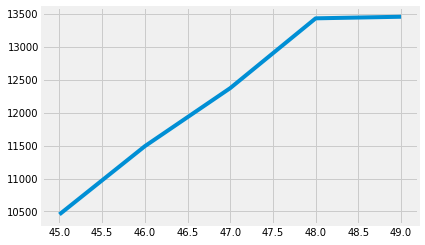

In [74]:
# plt.plot(y_test_confirmed)
# plt.plot(test_bayesian_pred)
# plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

In [0]:
#Kafi confusing hai raat ko koshih krta hu

# Testing Analysis

In [0]:
# link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSc_2y5N0I67wDU38DjDh35IZSIS30rQf7_NYZhtYYGU1jJYT6_kDx4YpF-qw0LSlGsBYP8pqM_a1Pd/pubhtml#'
# req = requests.get(link)
# soup = BeautifulSoup(req.content, "html.parser")

In [0]:
# Statewise tested numbers data

testing_data = getDataFromSheet(id='486127050', index=3)

# Filtering non-essential data
testing_data = testing_data[["Updated On", "State", "Total Tested", "Positive", "Negative", "Unconfirmed"]]

testing_data.head(5)

In [0]:
# Removing redundant entries
testing_data = testing_data[testing_data['Updated On'] != '']

testing_data['Updated On'].unique()

In [0]:
# Converting date string to datatime objects
testing_data['Updated On'] = pd.to_datetime(testing_data['Updated On'], format='%d/%m/%Y')

# Removing wrong data entry
testing_data = testing_data[ testing_data['Total Tested'] != '14/04/2020' ]

testing_data['Total Tested'].unique()

In [0]:
# Converting strings to floating point values after removing ','

testing_data.replace(to_replace="", value="0", inplace=True)   ######VERY CRUCIAL, WITHOUT THIS CODE BREAKS, IDK WHY THOUGH {TOOK 30 MIN TO FIND}

testing_data['Total Tested'] = testing_data['Total Tested'].str.replace(',', '').astype(float)
testing_data['Positive'] = testing_data['Positive'].str.replace(',', '').astype(float)
testing_data['Negative'] = testing_data['Negative'].str.replace(',', '').astype(float)
testing_data['Unconfirmed'] = testing_data['Unconfirmed'].str.replace(',', '').astype(float)

In [0]:
last_updated_on = testing_data['Updated On'].max()

# Seperating the data to be grouped

grouped_testing_data = testing_data

# Sorting the data according to the total number of tested cases

grouped_testing_data = grouped_testing_data.sort_values(['Total Tested'],ascending=False)

# Grouped_testing_data

grouped_testing_data = grouped_testing_data.groupby('Updated On')['Total Tested', 'Positive', 'Negative',
       'Unconfirmed'].sum().reset_index()

grouped_testing_data

In [0]:
# import time module to access time based functions
import time

# Create the date we want to exclude and convert it be a time object
d1 = "2020-02-04"
newdate1 = time.strptime(d1, "%Y-%m-%d")

# remove the date
grouped_testing_data = grouped_testing_data[grouped_testing_data['Updated On'] != d1 ]
grouped_testing_data

# Saving The Cleaned Data

In [0]:
## CLEANED DATA FOR TESTING ANALYSIS

grouped_testing_data.to_csv('/drive/My Drive/Covid19/grouped_testing_data.csv')

In [0]:
# Bar graph which showcases the total number of tests conducted daywise in India

fig = px.bar(grouped_testing_data,
             x='Updated On', y='Total Tested',
             title='Tests Conducted state-wise in India: ', text='Total Tested', height=800, width=1000)

fig.show()

# Quick Analysis( Obesity )

In [0]:
flg = data.groupby('Detected state')['confirmed', 'death', 'recovered', 'active'].sum().reset_index()

flg['mortalityRate'] = round((flg['death']/flg['confirmed'])*100, 2)

temp = flg[flg['confirmed']>10]
temp = temp.sort_values('mortalityRate', ascending=False)

# print(flg)

fig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:8][::-1],
             x = 'mortalityRate', y = 'Detected state', 
             title='Deaths per 10 Confirmed Cases', text='mortalityRate', height=500, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()

# Git Integration:

## File > Save a Copy to Git

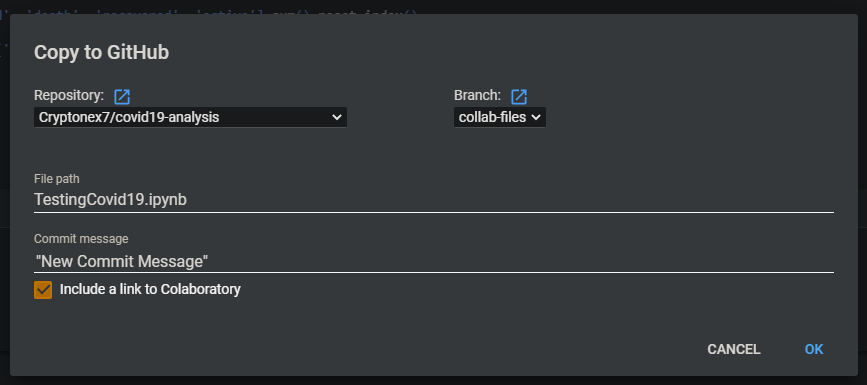